In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

In [2]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
def plot_ransac_revised(segment_data_x, segment_data_y):
    from skimage.measure import LineModelND, ransac
    data = np.column_stack([segment_data_x, segment_data_y])

    # fit line using all data
    model = LineModelND()
    model.estimate(data)

    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                                   residual_threshold=5, max_trials=1000)
    outliers = inliers == False

    # generate coordinates of estimated models
    line_x = np.array([segment_data_x.min(), segment_data_x.max()])
    line_y = model.predict_y(line_x)
    line_y_robust = model_robust.predict_y(line_x)
    k = (line_y_robust[1] - line_y_robust[0]) / (line_x[1] - line_x[0])
    m = line_y_robust[0] - k * line_x[0]
    x0 = (segment_data_y.min() - m) / k
    x1 = (segment_data_y.max() - m) / k
    line_x_y = np.array([x0, x1])
    line_y_robust_y = model_robust.predict_y(line_x_y)
    if (distance(line_x[0], line_y_robust[0], line_x[1], line_y_robust[1]) <
            distance(line_x_y[0], line_y_robust_y[0], line_x_y[1], line_y_robust_y[1])):
                # plt.plot(line_x, line_y_robust, '-b', label='Robust line model')
        line_twopoint = (line_x, line_y_robust)
    else:
                # plt.plot(line_x_y, line_y_robust_y, '-b', label='Robust line model')
        line_twopoint = (line_x_y, line_y_robust_y)

    return inliers, outliers, line_twopoint


def line_intersection(line1, line2, x_min, x_max, y_min, y_max):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    # 범위 내의 값인지 체크
    if x_min - 100 <= x <= x_max + 100 and y_min - 100 <= y <= y_max + 100:
        return x, y
    else:
        return -12345, -12345

def coord_sort(x):
    x = np.array(x)
    k = x[:,0]
    s = k.argsort()
    centers_sorted = x[s]
    for i in range(len(centers_sorted)//2):
        b = centers_sorted[2*i:2*(i+1),:]
        k = b[:,1]
        s = k.argsort()
        centers_sorted[2*i:2*(i+1), :] = b[s]
    return centers_sorted

def homography(img, points, width = 600, height = 300):
    pts1 = np.float32(coord_sort(points))
    pts2 = np.float32([[0, 0], [width, 0],[0,height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # img = img_to_coord(img)
    img = cv2.warpPerspective(img, matrix, (width, height))
    return img

def cluster(point_data, n_cluster=8):
    '''
    <input>
    point_data: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    n_cluster: 클러스터링할 그룹의 수

    <output>
    centers: 중심점 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )
    '''
    model = KMeans(n_clusters=n_cluster)
    model.fit(point_data)
    predict = model.predict(point_data)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(predict))))
    k_means_labels = model.labels_
    k_means_cluster_centers = model.cluster_centers_
    for k, col in zip(range(n_cluster), colors):
        my_members = (k_means_labels == k)

        # 중심 정의
        cluster_center = k_means_cluster_centers[k]

    centers = np.array(k_means_cluster_centers, dtype=int)
    return centers


def draw_dab_distances(centers):
    '''
    <input>
    centers: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )

    <output>
    없음
    '''
    centers_x = centers[:,0]  # x 좌표 집합
    centers_y = centers[:,1]  # y 좌표 집합
    distances_vert = []
    distances_horiz = []
    alpha = 1 # 보정계수, projectvie transformation에 적용했던 실제 사이즈 축적의 역수. 1:1 -> 1, 절반크기로 했으면 2, 2배 크기로 했으면 1/2
    for k in range(0, len(centers) ,2):
        distances_vert.append(round(Point(centers[k]).distance(Point(centers[k+1]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+1]),(centers_y[k],centers_y[k+1]), marker="o",linestyle=":") # 선 그리기
        plt.text((centers_x[k] + centers_x[k+1])/2 ,(centers_y[k]+centers_y[k+1])/2, distances_vert[-1], color="white") # 거리값 쓰기
    for k in range(0, int(len(centers)/2)+1):
        distances_horiz.append(round(Point(centers[k]).distance(Point(centers[k+2]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+2]),(centers_y[k],centers_y[k+2]), marker="s",linestyle="--")
        plt.text((centers_x[k]+centers_x[k+2])/2 ,(centers_y[k]+centers_y[k+2])/2, distances_horiz[-1],color="white")
def ribbon_gap(ribbon_homo, axis):
    if axis == "0":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif axis == "1":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff


In [3]:
xy = np.load('ribbon_point.npy')
img_dir = "./IMG_4245_JPG.rf.63460a44ffb7591e4ab7aaa7483d11e6.jpg"
img = cv2.imread(img_dir)

In [4]:
x_data = xy[:, 0]
y_data = xy[:, 1]
x_tmp = x_data.copy()
y_tmp = y_data.copy()
ransac_line = []
intersection_points = []
while True:
    inliers, outliers, line_twopoint = plot_ransac_revised(x_tmp, y_tmp)

    if x_tmp[inliers].shape[0] >= 2:
        # inliers, two points for line 기록 저장
        ransac_line.append((x_tmp[inliers], y_tmp[inliers], line_twopoint))

    # 나머지 점들 (outliers)
    x_tmp = x_tmp[outliers]
    y_tmp = y_tmp[outliers]

    # if x_tmp.shape[0] <= 2 or len(ransac_line) == 4:
    if len(ransac_line) == 4:
        break
x_min, x_max, y_min, y_max = x_data.min(), x_data.max(), y_data.min(), y_data.max()
for i in range(len(ransac_line)):
    for j in range(i + 1, len(ransac_line)):
        (x1, x2), (y1, y2) = ransac_line[i][2]
        (x3, x4), (y3, y4) = ransac_line[j][2]
        x, y = line_intersection([[x1, y1], [x2, y2]], [[x3, y3], [x4, y4]], x_min, x_max, y_min, y_max)
        if x != -12345 or y != -12345:
            intersection_points.append(np.array((x, y)))


intersection_points

[array([110.10978, 462.7685 ], dtype=float32),
 array([242.78186, 151.68407], dtype=float32),
 array([438.00226, 493.5675 ], dtype=float32),
 array([441.69705, 164.74637], dtype=float32)]

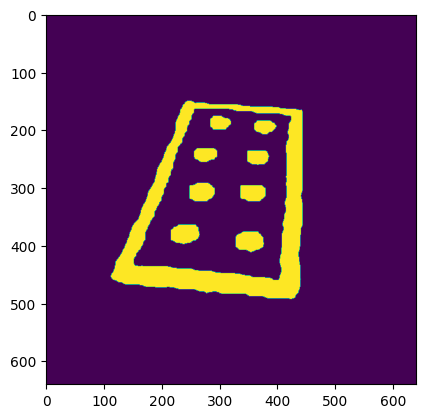

In [5]:
whole = np.load('whole_save.npy')
whole[whole == 1] = 255
plt.imshow(whole)

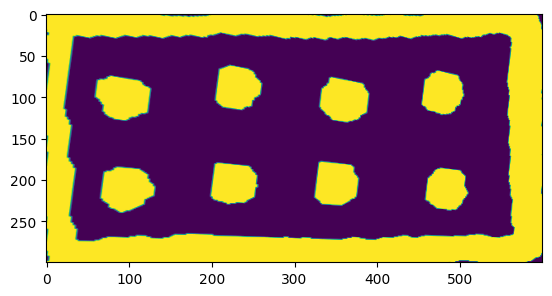

In [6]:
whole_homo = homography(whole, intersection_points)
plt.imshow(whole_homo)
plt.show()

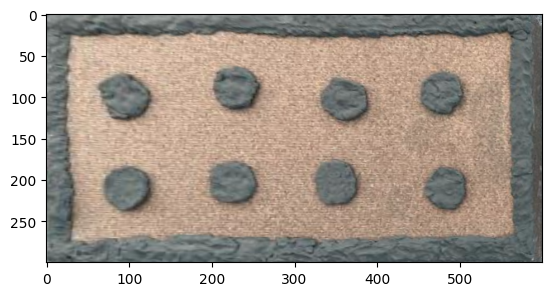

In [7]:
plt.imshow(homography(img, intersection_points))
plt.show()

In [8]:
xy = np.where(whole_homo > 255)
x_data = xy[0]
y_data = xy[1]

In [9]:
xys = np.stack((x_data, y_data), axis=1)

cluster_dab = cluster(xys)
plt.scatter(cluster_dab[:,0], cluster_dab[:,1])
plt.imshow(homography(img, intersection_points))
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by KMeans.

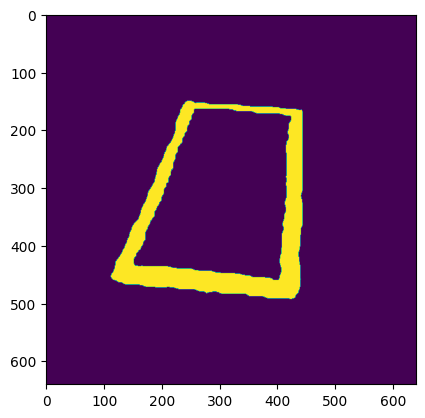

In [10]:
ribbon = np.load('segmented8.npy')
plt.imshow(ribbon)
plt.show()

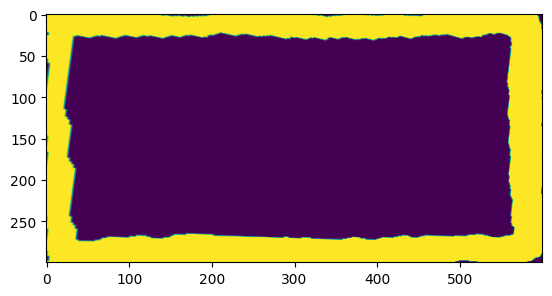

In [11]:
ribbon_homo = homography(ribbon, intersection_points)
plt.imshow(ribbon_homo)

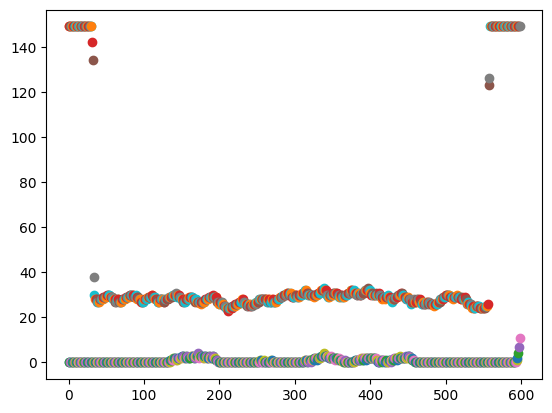

In [12]:
y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
for x in range(y_cut_ribbon.shape[1]-1):
    y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
    y_min_value = np.min(y_cut_idx)
    y_max_value = np.max(y_cut_idx)
    plt.scatter(x, y_min_value)
    plt.scatter(x, y_max_value)
plt.show()

In [13]:
y_diff = []
y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
for x in range(y_cut_ribbon.shape[1]-1):
    y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
    y_min_value = np.min(y_cut_idx)
    y_max_value = np.max(y_cut_idx)
    y_diff.append(y_max_value - y_min_value)
y_diff = np.array(y_diff)
print(y_diff)
print(np.min(y_diff))

[149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 142 134  38  30  28
  28  28  27  27  27  28  28  28  28  28  29  29  29  29  29  30  30  30
  30  29  29  29  29  28  28  28  27  27  28  28  28  27  27  27  27  28
  28  28  28  28  29  29  29  29  29  30  30  30  30  30  30  29  29  30
  28  29  29  28  28  28  27  27  27  27  28  28  28  28  28  29  29  29
  29  29  30  30  29  29  29  28  28  28  27  27  27  28  28  28  28  28
  27  27  28  28  28  28  28  29  29  28  28  28  29  28  28  28  28  30
  28  28  28  27  27  26  25  25  24  25  25  26  25  25  26  26  27  27
  26  26  26  25  26  25  25  25  24  24  23  25  24  23  24  24  25  25
  24  25  25  26  26  26  26  26  27  27  27  27  26  27  27  28  28  26
  27  26  26  27  27  27  26  26  25  25  25  24  24  23  24  24  24  24
  24  25  25  25  25  26  26  26  26  26  27  27  27  27  28  28  27  27
  26  26  26  25  25  26  26  25  25  25  26  26  2

In [14]:
x_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]

x_diff = []
for y in range(x_cut_ribbon.shape[0]-1):
    y_cut_idx = np.where(x_cut_ribbon[y,:]>0)
    y_min_value = np.min(y_cut_idx)
    y_max_value = np.max(y_cut_idx)
    x_diff.append(y_max_value - y_min_value)
x_diff = np.array(x_diff)
print(x_diff)
print(np.min(x_diff))

[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299 299 299 299 299 298 299 299 299 299 299 295 295  33  33  33  33
  33  33  33  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30
  30  30  30  30  30  30  29  26  26  27  27  27  27  27  26  26  26  27
  27  27  27  27  26  26  27  27  27  27  27  26  26  26  26  26  26  26
  26  25  25  25  25  25  25  25  24  24  24  24  24  24  24  23  23  23
  23  23  23  23  23  22  22  25  25  25  25  25  24  24  24  24  26  27
  27  27  29  29  29  29  29  29  32  31  31  31  31  31  31  31  31  30
  30  30  30  30  30  30  29  29  29  29  29  29  29  29  28  28  28  28
  28  28  28  27  27  27  26  26  27  27  27  26  29  29  29  29  32  32
  31  33  34  34  34  34  36  36  36  36  36  36  36  36  35  35  35  35
  35  35  35  34  34  34  34  34  34  34  34  33  33  33  33  33  33  33
  32  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30  30  30
  30  30  30  30  30  29  29  29  29  29  32  32  3

In [15]:
def ribbon_gap(ribbon_homo, flag):
    if flag == "x":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif flag == "y":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff
    
y_gap = ribbon_gap(ribbon_homo, "y")
print(y_gap)



# y_diff = []
# y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
# for x in range(y_cut_ribbon.shape[1]-1):
#     y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
#     y_min_value = np.min(y_cut_idx)
#     y_max_value = np.max(y_cut_idx)
#     y_diff.append(y_max_value - y_min_value)
# y_diff = np.array(y_diff)
# print(y_diff)
# print(np.min(y_diff))

[149 149 149 ... 143 142 141]


In [16]:
def ribbon_gap(ribbon_homo, axis):
    if axis == "0":
        y_diff = []
        y_cut_ribbon = ribbon_homo[:, 0:int(ribbon_homo.shape[1]/2)]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[:, int(ribbon_homo.shape[1]/2):]
        for y in range(y_cut_ribbon.shape[0]):
            y_cut_idx = np.where(y_cut_ribbon[y, :]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    elif axis == "1":
        y_diff = []
        y_cut_ribbon = ribbon_homo[0:int(ribbon_homo.shape[0]/2), :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
        y_cut_ribbon = ribbon_homo[int(ribbon_homo.shape[0]/2):, :]
        for x in range(y_cut_ribbon.shape[1]):
            y_cut_idx = np.where(y_cut_ribbon[:,x]>0)
            y_min_value = np.min(y_cut_idx)
            y_max_value = np.max(y_cut_idx)
            y_diff.append(y_max_value - y_min_value)
    y_diff = np.array(y_diff)
    # print(y_diff)
    # print(np.min(y_diff))
    
    return y_diff
    
y_gap = ribbon_gap(ribbon_homo, axis = "0")
print(y_gap)


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299 299 299 299 299 298 299 299 299 299 299 295 295  33  33  33  33
  33  33  33  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30
  30  30  30  30  30  30  29  26  26  27  27  27  27  27  26  26  26  27
  27  27  27  27  26  26  27  27  27  27  27  26  26  26  26  26  26  26
  26  25  25  25  25  25  25  25  24  24  24  24  24  24  24  23  23  23
  23  23  23  23  23  22  22  25  25  25  25  25  24  24  24  24  26  27
  27  27  29  29  29  29  29  29  32  31  31  31  31  31  31  31  31  30
  30  30  30  30  30  30  29  29  29  29  29  29  29  29  28  28  28  28
  28  28  28  27  27  27  26  26  27  27  27  26  29  29  29  29  32  32
  31  33  34  34  34  34  36  36  36  36  36  36  36  36  35  35  35  35
  35  35  35  34  34  34  34  34  34  34  34  33  33  33  33  33  33  33
  32  32  32  32  32  32  32  32  31  31  31  31  31  31  31  30  30  30
  30  30  30  30  30  29  29  29  29  29  32  32  3

In [17]:
y_cut_idx.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [18]:
X = y_cut_idx[0, :]
Y = y_cut_idx[1, :]
# X 값을 고정
fixed_X_index = 150  # 예를 들어, X 값을 고정하려는 인덱스를 선택
fixed_X_value = X[np.fixed_X_index]

# X 값을 고정한 상태에서 Y 값의 차를 구함
Y_diff = Y - Y[fixed_X_index]

print("X 값:", fixed_X_value)
print("Y 값의 차:", Y_diff)


TypeError: tuple indices must be integers or slices, not tuple

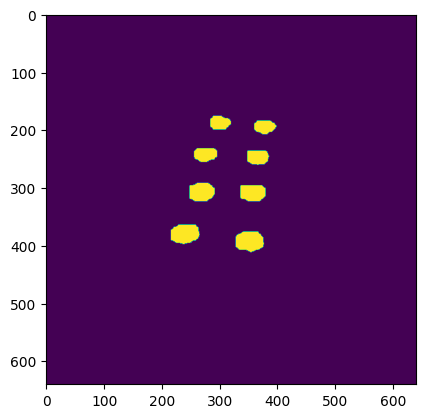

In [19]:
import numpy as np

# 로드할 파일들의 개수
num_files = 8

# 로드한 데이터를 저장할 리스트
segmented_data = []

# 파일을 로드하는 루프
for i in range(num_files):
    filename = f'segmented{i}.npy'
    data = np.load(filename)
    segmented_data.append(data)

combined_data = np.sum(segmented_data, axis=0)

# segmented_data에는 이제 각각의 segmented 데이터가 저장됨
plt.imshow(combined_data)

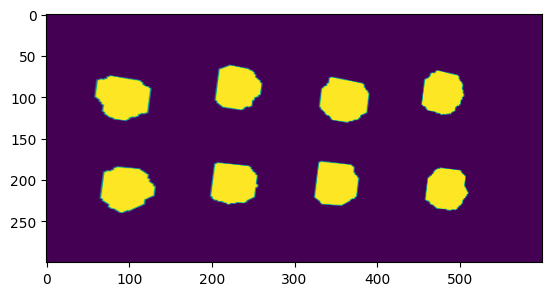

In [20]:
dab_homo = homography(combined_data, intersection_points)
plt.imshow(dab_homo)

In [21]:
import numpy as np

# 배열에서 값이 1인 요소의 인덱스 찾기
indices = np.where(dab_homo > 0)

# 인덱스를 좌표로 변환
points = list(zip(indices[0], indices[1]))

print(points)

[(62, 221), (62, 222), (62, 223), (63, 218), (63, 219), (63, 220), (63, 221), (63, 222), (63, 223), (63, 224), (63, 225), (63, 226), (63, 227), (63, 228), (64, 213), (64, 216), (64, 217), (64, 218), (64, 219), (64, 220), (64, 221), (64, 222), (64, 223), (64, 224), (64, 225), (64, 226), (64, 227), (64, 228), (64, 229), (64, 230), (64, 231), (64, 232), (64, 233), (64, 234), (65, 211), (65, 212), (65, 213), (65, 214), (65, 215), (65, 216), (65, 217), (65, 218), (65, 219), (65, 220), (65, 221), (65, 222), (65, 223), (65, 224), (65, 225), (65, 226), (65, 227), (65, 228), (65, 229), (65, 230), (65, 231), (65, 232), (65, 233), (65, 234), (65, 235), (65, 236), (65, 237), (65, 238), (65, 239), (66, 208), (66, 209), (66, 210), (66, 211), (66, 212), (66, 213), (66, 214), (66, 215), (66, 216), (66, 217), (66, 218), (66, 219), (66, 220), (66, 221), (66, 222), (66, 223), (66, 224), (66, 225), (66, 226), (66, 227), (66, 228), (66, 229), (66, 230), (66, 231), (66, 232), (66, 233), (66, 234), (66, 235)

In [22]:
cluster_dab = cluster(points)
print(cluster_dab)

[[101  92]
 [104 360]
 [211  96]
 [ 95 479]
 [204 226]
 [ 89 230]
 [211 483]
 [205 350]]


In [60]:
dab_homo.shape

(300, 600)

In [42]:
def coord_to_img(coord):
    coord = cv2.flip(coord, 0)
    coord = cv2.rotate(coord, cv2.ROTATE_90_CLOCKWISE)
    return coord
def img_to_coord(img):
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img = cv2.flip(img, 0)
    return img

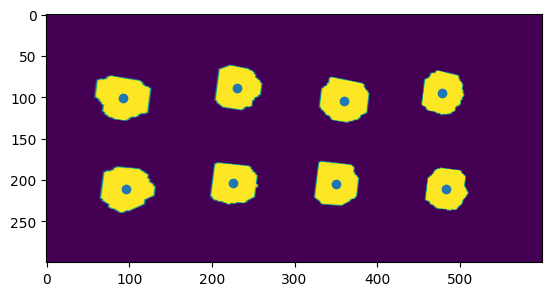

In [61]:
plt.scatter(cluster_dab[:,1],cluster_dab[:,0]) #####제발 y,x로 scatter 해라
plt.imshow(dab_homo)
plt.show()

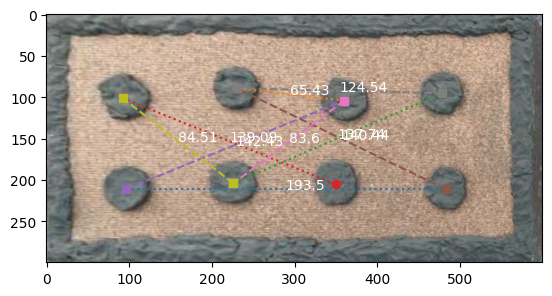

In [71]:
from shapely.geometry import Point

def draw_dab_distances(centers):
    '''
    <input>
    centers: 중심점을 구할 포인트 집합 ( np.array([[x1,y1], [x2,y2], [x3,y3]....]]) )

    <output>
    없음
    '''
    centers_x = centers[:,1]  # x 좌표 집합
    centers_y = centers[:,0]  # y 좌표 집합
    distances_vert = []
    distances_horiz = []
    alpha = 1/2 # 보정계수, projectvie transformation에 적용했던 실제 사이즈 축적의 역수. 1:1 -> 1, 절반크기로 했으면 2, 2배 크기로 했으면 1/2
    for k in range(0, len(centers) ,2):
        distances_vert.append(round(Point(centers[k]).distance(Point(centers[k+1]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+1]),(centers_y[k],centers_y[k+1]), marker="o",linestyle=":") # 선 그리기
        plt.text((centers_x[k] + centers_x[k+1])/2 ,(centers_y[k]+centers_y[k+1])/2, distances_vert[-1], color="white") # 거리값 쓰기
    for k in range(0, int(len(centers)/2)+1):
        distances_horiz.append(round(Point(centers[k]).distance(Point(centers[k+2]))*alpha, 2))
        plt.plot((centers_x[k], centers_x[k+2]),(centers_y[k],centers_y[k+2]), marker="s",linestyle="--")
        plt.text((centers_x[k]+centers_x[k+2])/2 ,(centers_y[k]+centers_y[k+2])/2, distances_horiz[-1],color="white")

draw_dab_distances(cluster_dab)
plt.imshow(homography(img, intersection_points))
plt.show()